In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip \*.zip  && rm *.zip

 99% 1.20G/1.21G [00:05<00:00, 248MB/s]
100% 1.21G/1.21G [00:05<00:00, 234MB/s]
Archive:  gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz
!tar -xvf  genres.tar.gz

In [ ]:
!du -sh * 

1.4G	Data
1.3G	genres
1.2G	genres.tar.gz
28M	genres.tar.gz.1
4.0K	kaggle.json
55M	sample_data


In [4]:
import librosa
import IPython.display as ipd
import sklearn
import matplotlib.pyplot as plt
import librosa.display
import glob
import numpy as np



In [5]:
class preprocess:
    def __init__(self,path):
        self.x, self.sr = librosa.load(path)
        self.spec=librosa.stft(self.x)
        
    def wave_plot(self):
        plt.figure(figsize=(14, 5))
        librosa.display.waveplot(self.x, sr=self.sr)
    
    def spectrogram_plot(self):
        X = librosa.stft(self.x)
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(Xdb, sr=self.sr, x_axis='time', y_axis='log')
        plt.colorbar()

    def create_spectogram(self):
        spect = librosa.feature.melspectrogram(y=self.x, sr=self.sr,n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        return spect   


    

    


In [6]:
genre_list=['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
genre_label=np.arange(10)
X_spect = np.empty((0, 128, 640))
class_label=[]

In [ ]:
X_spect = np.empty((0, 640, 128))
aud=preprocess('genres/blues/blues.00000.wav')
spect=aud.create_spectogram().copy()
 # Adjusting the size to be 128 x 660
if spect.shape[1] != 660:
    spect.resize(128,660, refcheck=False)
spect.shape
#spect = spect[:640, :]
#X_spect = np.append(X_spect, [spect], axis=0)


(128, 660)

(1, 640, 128)


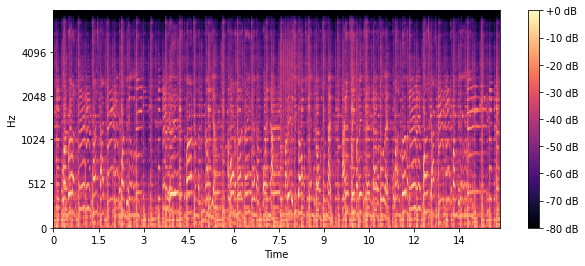

In [ ]:
print(X_spect.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [7]:
def read_file(enter_genre):
    list_of_files = glob.glob('genres/'+enter_genre+'/./*.wav')
    global class_label,X_spect    
    for path in list_of_files:
      
        aud=preprocess(path)
        spect=aud.create_spectogram()
        #spect.shape
        spect = spect[:, :640] # Normalize for small shape differences
        X_spect = np.append(X_spect, [spect], axis=0)
        class_label.append(enter_genre)
    


In [8]:
# blue_dir
#headers=[zero_c_mean,zero_c_var,spec_cent_mean,spec_cent_var,spec_roll_mean,spec_roll_var,spec_flux_mean,spec_flux_var,low_enery,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var]
read_file('blues')
read_file('classical')
read_file('country')
read_file('disco')
read_file('hiphop')
read_file('jazz')
read_file('metal')
read_file('pop')
read_file('reggae')
read_file('rock')

In [ ]:
X_spect.shape
len(class_label)

1000

In [9]:
Data_array=np.array(X_spect)
class_label=np.array(class_label)

In [ ]:
Data_array.shape

(1000, 128, 640)

In [10]:
from sklearn.preprocessing import LabelEncoder
class_list = class_label
Label_encoder = LabelEncoder()

In [11]:
y = Label_encoder.fit_transform(class_list)
X = Data_array.reshape(((-1, 128, 640, 1)))
X /= X.min()

In [12]:
from sklearn.preprocessing import StandardScaler
Scale = StandardScaler()
#X = Scale.fit_transform(Data_array)
print(X.min())

-4.76837158203125e-08


In [79]:
#Spliting
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, shuffle=True, test_size=.30)
X_train.shape

(700, 128, 640, 1)

In [80]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(700, 128, 640, 1)
(300, 128, 640, 1)
(700,)
(300,)


#CNN Model

In [81]:
from keras import regularizers
from keras import losses
from keras.models import Sequential 
from keras.layers import Dense, Activation, LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop,SGD,Adam
# Plot
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [82]:
#ConvolutionalDeepNeuralNetwork
class DNN_Model:

  def trainModel(self, model, epochs, optimizer,batch_size):
    
    model.compile(optimizer = optimizer,
                  loss = 'sparse_categorical_crossentropy',
                  metrics='accuracy')
    return model.fit(X_train,y_train,
                    validation_data = (X_test,y_test),
                    epochs= epochs,
                    batch_size=batch_size)
    
  # Create the model
  def generate_model(self, dropout_rate=0.2,l2_rate=0.0):
    model = Sequential()
    #Layer_1
    model.add(Dense(units=128, activation='relu',input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(Dropout(dropout_rate))




    model.add(Dense(units=10, activation='softmax',kernel_regularizer=regularizers.l2(l2_rate) ))
    model.summary()
    return model;

  def cnn(self ,dropout_rate=0,l2_rate=0.0, num_genres=10):
    model = Sequential()
    # layer 1
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(128, 640, 1), strides=(1,1), padding = 'Same' ,kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(MaxPooling2D(pool_size=(2, 4)))

     # layer 2
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', strides=(1,1), padding = 'Same' ,kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(MaxPooling2D(pool_size=(2, 4)))

    # layer 3
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', strides=(1,1), padding = 'Same' ,kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(MaxPooling2D(pool_size=(2, 4)))

     #Flatten
    model.add(Flatten())



    #Flatten
    model.add(Flatten())


    #dense
    model.add(Dense(units=128, activation='elu',kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(Dropout(dropout_rate))

    #dense
    model.add(Dense(units=64, activation='elu',kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=num_genres, activation='softmax',kernel_regularizer=regularizers.l2(l2_rate) ))
    model.summary()

    return(model)

  def cnn2(self):
    np.random.seed(23456)
    

    # Initiating an empty neural network
    cnn_model = Sequential(name='cnn_1')
    # Adding convolutional layer
    cnn_model.add(Conv2D(filters=8,
                        kernel_size=(3,3),
                        activation='relu',
                        input_shape=(640,128,1)))

    # Adding max pooling layer
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))

    # Adding convolutional layer
    cnn_model.add(Conv2D(filters=16,
                        kernel_size=(3,3),
                        activation='relu'))

    # Adding max pooling layer
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))

    # Adding convolutional layer
    cnn_model.add(Conv2D(filters=32,
                        kernel_size=(3,3),
                        activation='relu'))

    # Adding max pooling layer
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))

    # Adding a flattened layer to input our image data
    cnn_model.add(Flatten())

     # Adding a dense layer with 128 neurons
    cnn_model.add(Dense(128, activation='relu'))

    # Adding a dropout layer for regularization
    cnn_model.add(Dropout(0.25))

    # Adding an output layer
    cnn_model.add(Dense(10, activation='softmax'))

    cnn_model.summary()
    return cnn_model;


In [83]:
batch_size = 64
dnn_model = DNN_Model()
model = dnn_model.cnn(dropout_rate=0.25,l2_rate=0.001)
#model = dnn_model.cnn2()
history = dnn_model.trainModel(model = model, epochs=100 , optimizer='adam',batch_size=batch_size)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 640, 8)       80        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 160, 8)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 160, 16)       1168      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 40, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 40, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 10, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5120)             

Test loss: 1.235808253288269 / Test accuracy: 0.7200000286102295


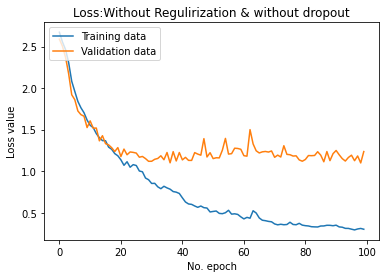

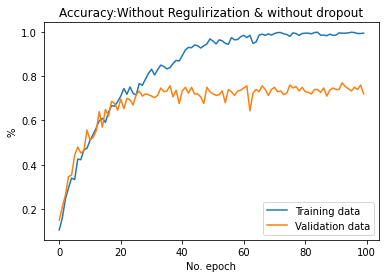

In [84]:
#Evaluation metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
# Plot history: Loss
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss:Without Regulirization & without dropout')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
# Plot history: Accuracy
plt.plot(history.history['accuracy'], label='Training data')
plt.plot(history.history['val_accuracy'], label='Validation data')
plt.title('Accuracy:Without Regulirization & without dropout')
plt.ylabel('%')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

In [85]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=genre_list))

(300,) (300,)
              precision    recall  f1-score   support

       blues       0.62      0.78      0.69        27
   classical       0.67      1.00      0.80        33
     country       0.71      0.79      0.75        28
       disco       0.71      0.67      0.69        30
      hiphop       0.88      0.82      0.85        34
        jazz       0.83      0.52      0.64        29
       metal       0.81      0.85      0.83        26
         pop       0.83      0.65      0.73        31
      reggae       0.70      0.63      0.67        30
        rock       0.53      0.50      0.52        32

    accuracy                           0.72       300
   macro avg       0.73      0.72      0.72       300
weighted avg       0.73      0.72      0.72       300



In [86]:
from keras.utils import np_utils
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 12ms/step - loss: 1.2358 - accuracy: 0.7200


[1.235808253288269, 0.7200000286102295]

In [87]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[21  2  2  1  0  1  0  0  0  0]
 [ 0 33  0  0  0  0  0  0  0  0]
 [ 0  2 22  1  0  0  0  0  1  2]
 [ 2  0  0 20  1  0  0  0  4  3]
 [ 0  0  1  2 28  0  0  1  1  1]
 [ 4  7  1  0  0 15  0  2  0  0]
 [ 1  0  0  0  1  0 22  0  0  2]
 [ 0  1  1  1  0  0  1 20  2  5]
 [ 2  1  1  3  1  1  1  0 19  1]
 [ 4  3  3  0  1  1  3  1  0 16]]


0.72


0.72


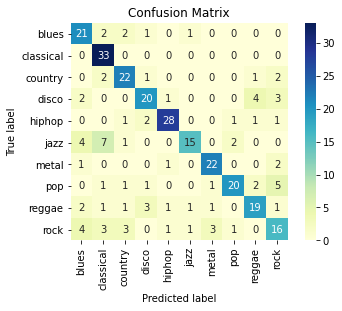

In [115]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

### 10 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns

ax = plt.axes()
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat,cmap="YlGnBu", square=True, annot=True, fmt='d',ax=ax, cbar=True,
            xticklabels=genre_list,
            yticklabels=genre_list)
ax.set_title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');

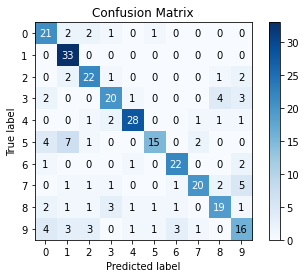

In [94]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_true, y_pred)
